# Cloud Catalog Demo (using MMS data in HelioCloud S3 storage)

- https://github.com/heliocloud-data/science-tutorials/blob/main/MMS-Catalog-Demo.ipynb
- https://github.com/heliocloud-data/cloudcatalog

The CloudCatalog specification and accompanying Python client and demo notebook are a method for efficiently getting a list of data files stored in AWS S3 that are publicly accessible to scientists. In addition to querying which datasets are available, users can directly retrieve the list of files in the form of 'time, S3 file key, filesize' as a Pandas DataFrame.

We jump into a quick demo of fetching a day's worth of MMS1 files. We then step back to show how to query the 'catalog of catalogs' to explore and find datasets. We close with a more extended MMS demo that fetches the list of files then plots them directly from cloud storage (no intermediate file transfers needed).

## Setup

In [ ]:
import cloudcatalog
import cdflib
import matplotlib.pyplot as plt

# HAPI-like queries

We will start with the main usage, 'give me a list of files to operate on', then backfill the way to search and explore catalogs after this example case.

CloudCatalog uses a HAPI-like query to get a list of files for a given dataset id, over a given time range. For example:

In [ ]:
# one sample instruments and a time range
dataset_id1 = 'mms1_feeps_brst_electron'
start =  '2020-02-01T00:00:00Z'
stop  =  '2020-02-02T00:00:00Z'

In [ ]:
# open up the global Catalog
cr = cloudcatalog.CatalogRegistry()
fr = cloudcatalog.CloudCatalog("s3://gov-nasa-hdrl-data1/")

In [ ]:
filekeys_id1 = fr.request_cloud_catalog(dataset_id1,start_date=start,stop_date=stop)

In [ ]:
filekeys_id1

,start,stop,datakey,filesize
589,2020-01-31 21:03:23,2020-02-01 07:55:23,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,1513848
590,2020-02-01 07:55:23,2020-02-01 08:17:13,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,1521034
591,2020-02-01 08:17:13,2020-02-01 08:19:23,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3166628
592,2020-02-01 08:19:23,2020-02-01 08:21:33,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3166628
593,2020-02-01 08:21:33,2020-02-01 08:23:43,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3166628
594,2020-02-01 08:23:43,2020-02-01 08:26:03,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3396580
595,2020-02-01 08:26:03,2020-02-01 08:28:13,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3166628
596,2020-02-01 08:28:13,2020-02-01 08:30:23,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3159442
597,2020-02-01 08:30:23,2020-02-01 08:37:13,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3152256
598,2020-02-01 08:37:13,2020-02-01 08:39:33,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3396580


## Params

Now you can feed that list of file S3 locations to your program and work with your files. Here's a simple example of looking at the metadata for the (arbitrarily chosen) 3rd file in that Pandas DataFrame:

In [ ]:
print("All info on item 3:",filekeys_id1.iloc[2])

All info on item 3: start                                     2020-02-01 08:17:13
stop                                      2020-02-01 08:19:23
datakey     s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...
filesize                                              3166628
Name: 591, dtype: object


In [ ]:
print("Just the S3 key:",filekeys_id1.iloc[2]['datakey'])

Just the S3 key: s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/feeps/brst/l2/electron/2020/02/mms1_feeps_brst_l2_electron_20200201081713_v6.1.1.cdf


You can skip to the example at the end, where we actually access the files. But first, what is CloudCatalog and how to use?

# Catalog of Catalogs

Now we step back to explore the catalogs that are available, to work up to that example.

The `CatalogRegistry()` call fetches a list of all S3 'buckets' (data repositories) that are known to the HelioCloud network. This is the 'catalog of catalogs'.

In [ ]:
cr = cloudcatalog.CatalogRegistry()

In [ ]:
cat = cr.get_catalog()
print("get_catalog() provides JSON metadata for the Catalog of Catalogs, plus a list of known catalogs:",cat)

get_catalog() provides JSON metadata for the Catalog of Catalogs, plus a list of known catalogs: {'version': '0.4', 'modification': '2022-01-01T00:00Z', 'registry': [{'endpoint': 's3://gov-nasa-hdrl-data1/', 'name': 'HelioCloud, including SDO', 'region': 'us-east-1'}]}


In [ ]:
reg = cr.get_registry()
print("get_registry() is a list of all known endpoints:",reg)

get_registry() is a list of all known endpoints: [{'endpoint': 's3://gov-nasa-hdrl-data1/', 'name': 'HelioCloud, including SDO', 'region': 'us-east-1'}]


In [ ]:
url = cr.get_endpoint("HelioCloud, including SDO")
print("get_endpoint:",url)

get_endpoint: s3://gov-nasa-hdrl-data1/


## Searching for data with EntireCatalogSearch

This initial search accesses each HelioCloud's specific data holdings to create what you probably want, which is a list of all datasets available within the entire HelioCloud ecosystem.

We include an example of a down or de-registered catalog to emphasize this index catalog points to HelioClouds, but doesn't manage them.

In [ ]:
mysearch = cloudcatalog.EntireCatalogSearch()

Now let us do something useful-- look for MMS1 FEEPS data, or ion data, or other items of interest.

In [ ]:
mysearch.search_by_id('mms1_feeps')

[{'id': 'mms1_feeps_brst_electron',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/feeps/brst/l2/electron/',
  'title': 'mms1/feeps/brst/l2/electron/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf',
  'description': 'Optional description for dataset',
  'resourceID': 'optional identifier e.g. SPASE ID',
  'creationDate': 'optional ISO 8601 date/time of the dataset creation',
  'citation': 'optional how to cite this dataset, DOI or similar',
  'contact': 'optional contact info, SPASE ID, email, or ORCID',
  'aboutURL': 'optional website URL for info, team, etc'},
 {'id': 'mms1_feeps_brst_ion',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/feeps/brst/l2/ion/',
  'title': 'mms1/feeps/brst/l2/ion/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf'},
 {'id': 'm

In [ ]:
mysearch.search_by_id('srvy_ion')

[{'id': 'mms1_feeps_srvy_ion',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/feeps/srvy/l2/ion/',
  'title': 'mms1/feeps/srvy/l2/ion/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf'},
 {'id': 'mms2_feeps_srvy_ion',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms2/feeps/srvy/l2/ion/',
  'title': 'mms2/feeps/srvy/l2/ion/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf'},
 {'id': 'mms3_feeps_srvy_ion',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms3/feeps/srvy/l2/ion/',
  'title': 'mms3/feeps/srvy/l2/ion/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf'},
 {'id': 'mms4_feeps_srvy_ion',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms4/fe

In [ ]:
mysearch.search_by_title('mms1/fpi/b')

[{'id': 'mms1_fpi_brst_des-dist',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/fpi/brst/l2/des-dist/',
  'title': 'mms1/fpi/brst/l2/des-dist/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf'},
 {'id': 'mms1_fpi_brst_des-moms',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/fpi/brst/l2/des-moms/',
  'title': 'mms1/fpi/brst/l2/des-moms/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf'},
 {'id': 'mms1_fpi_brst_dis-dist',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/fpi/brst/l2/dis-dist/',
  'title': 'mms1/fpi/brst/l2/dis-dist/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf'},
 {'id': 'mms1_fpi_brst_dis-moms',
  'index': 's3://gov-nasa-hdrl

In [ ]:
mysearch.search_by_title('des-dist')[:2]

[{'id': 'mms1_fpi_brst_des-dist',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/fpi/brst/l2/des-dist/',
  'title': 'mms1/fpi/brst/l2/des-dist/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf'},
 {'id': 'mms1_fpi_fast_des-dist',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/fpi/fast/l2/des-dist/',
  'title': 'mms1/fpi/fast/l2/des-dist/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf'}]

In [ ]:
mysearch.search_by_keywords(['mms2', 'brst', 'apples'])[:3]

[{'id': 'mms2_feeps_brst_electron',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms2/feeps/brst/l2/electron/',
  'title': 'mms2/feeps/brst/l2/electron/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf'},
 {'id': 'mms2_feeps_brst_ion',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms2/feeps/brst/l2/ion/',
  'title': 'mms2/feeps/brst/l2/ion/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf'},
 {'id': 'mms2_fgm_brst',
  'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms2/fgm/brst/l2/',
  'title': 'mms2/fgm/brst/l2/',
  'start': '2015-06-01T00:00.00Z',
  'stop': '2023-09-30T23:59.00Z',
  'modification': '2024-02-28T17:10.00Z',
  'indextype': 'csv',
  'filetype': 'cdf'}]

## Working with the global catalog (..the name)

This is primarily for admins and people looking for background information on other HelioClouds (rather than on other datasets).

In [ ]:
cr = cloudcatalog.CatalogRegistry()

In [ ]:
cr.get_catalog()

{'version': '0.4',
 'modification': '2022-01-01T00:00Z',
 'registry': [{'endpoint': 's3://gov-nasa-hdrl-data1/',
   'name': 'HelioCloud, including SDO',
   'region': 'us-east-1'}]}

In [ ]:
cr.get_registry()

[{'endpoint': 's3://gov-nasa-hdrl-data1/',
  'name': 'HelioCloud, including SDO',
  'region': 'us-east-1'}]

In [ ]:
endpoint = cr.get_endpoint('HelioCloud, including SDO')
endpoint

's3://gov-nasa-hdrl-data1/'

In [ ]:
cr.catalog

{'version': '0.4',
 'modification': '2022-01-01T00:00Z',
 'registry': [{'endpoint': 's3://gov-nasa-hdrl-data1/',
   'name': 'HelioCloud, including SDO',
   'region': 'us-east-1'}]}

## Working with a local catalog

Here we browse all the data holdings within a specific disk.

In [ ]:
fr=cloudcatalog.CloudCatalog("s3://gov-nasa-hdrl-data1/")                        

In [ ]:
catalogs = fr.get_catalog()['catalog']

In [ ]:
print(f"Here's the first four entries:")
for i in range(4): print(f"{catalogs[i]}")

Here's the first four entries:
{'id': 'aia_0094', 'title': 'AIA 0094 FITS data', 'index': 's3://gov-nasa-hdrl-data1/sdo/aia/registries/', 'start': '2010-05-13T00:00:00Z', 'stop': '2022-12-31T23:56:00Z', 'modification': '2023-05-04T00:00:00Z', 'indextype': 'csv', 'filetype': 'fits'}
{'id': 'aia_0131', 'index': 's3://gov-nasa-hdrl-data1/sdo/aia/registries/', 'title': 'AIA 0131 FITS data', 'start': '2015-06-01T00:00:00Z', 'stop': '2021-12-31T23:59:59Z', 'modification': '2023-05-04:00:00:00Z', 'indextype': 'csv', 'filetype': 'fits'}
{'id': 'aia_0171', 'index': 's3://gov-nasa-hdrl-data1/sdo/aia/registries/', 'title': 'AIA 0171 FITS data', 'start': '2015-06-01T00:00:00Z', 'stop': '2021-12-31T23:59:59Z', 'modification': '2023-05-04:00:00:00Z', 'indextype': 'csv', 'filetype': 'fits'}
{'id': 'aia_0193', 'index': 's3://gov-nasa-hdrl-data1/sdo/aia/registries/', 'title': 'AIA 0193 FITS data', 'start': '2015-06-01T00:00:00Z', 'stop': '2021-12-31T23:59:59Z', 'modification': '2023-05-04:00:00:00Z', '

# Useful search

Given a dataset ID (from searching above or by knowing a dataset name from another catalog or search tool or even email), we can get a list of files for our desired dataset within our desired timespan. Here's our example dataset from before:

In [ ]:
# one sample instruments and a time range
dataset_id1 = 'mms1_feeps_brst_electron'
start = '2020-02-01T00:00:00Z'
stop  = '2020-02-02T00:00:00Z'

Each dataset has metadata (in JSON format) providing additional information. Here is an example.

In [ ]:
print(fr.get_entry(dataset_id1))

{'id': 'mms1_feeps_brst_electron', 'index': 's3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/feeps/brst/l2/electron/', 'title': 'mms1/feeps/brst/l2/electron/', 'start': '2015-06-01T00:00.00Z', 'stop': '2023-09-30T23:59.00Z', 'modification': '2024-02-28T17:10.00Z', 'indextype': 'csv', 'filetype': 'cdf', 'description': 'Optional description for dataset', 'resourceID': 'optional identifier e.g. SPASE ID', 'creationDate': 'optional ISO 8601 date/time of the dataset creation', 'citation': 'optional how to cite this dataset, DOI or similar', 'contact': 'optional contact info, SPASE ID, email, or ORCID', 'aboutURL': 'optional website URL for info, team, etc'}


Now we get the actual file list of data items for our given instrument in our given time range.

In [ ]:
file_registry1 = fr.request_cloud_catalog(dataset_id1, start_date=start, stop_date=stop, overwrite=False)

In [ ]:
file_registry1

,start,stop,datakey,filesize
589,2020-01-31 21:03:23,2020-02-01 07:55:23,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,1513848
590,2020-02-01 07:55:23,2020-02-01 08:17:13,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,1521034
591,2020-02-01 08:17:13,2020-02-01 08:19:23,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3166628
592,2020-02-01 08:19:23,2020-02-01 08:21:33,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3166628
593,2020-02-01 08:21:33,2020-02-01 08:23:43,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3166628
594,2020-02-01 08:23:43,2020-02-01 08:26:03,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3396580
595,2020-02-01 08:26:03,2020-02-01 08:28:13,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3166628
596,2020-02-01 08:28:13,2020-02-01 08:30:23,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3159442
597,2020-02-01 08:30:23,2020-02-01 08:37:13,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3152256
598,2020-02-01 08:37:13,2020-02-01 08:39:33,s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/...,3396580


# Operating on files in bulk

Here we can view metadata about the files, or plot them and otherwise extract data from them.

First, some simple metadata.

In [ ]:
print('Python Hash of File | Start Date | End Date | File Size')
fr.stream(file_registry1[0:3], lambda bo, d, e, f: print(hash(bo.read()), d.replace(' ', 'T')+'Z', e.replace(' ','T')+'Z',f))

Python Hash of File | Start Date | End Date | File Size
1445128415434459948 2020-01-31T21:03:23Z 2020-02-01T07:55:23Z 1513848
1760780003097032233 2020-02-01T07:55:23Z 2020-02-01T08:17:13Z 1521034
-9037009860487071340 2020-02-01T08:17:13Z 2020-02-01T08:19:23Z 3166628


We define a plotting routine for CDF files here. You can (as with any code) define whatever functions you want to rip through each datafile. We chose to plot it for this demo to show the data is accessed via S3 and loaded into this program without having to copy any files around.

In [ ]:
def plot_cdf(s3_uri, d, e, f):
    print("fetching ",s3_uri)

    cdf = cdflib.CDF(s3_uri)

    # Get the variable name and its data
    #var_name = cdf.cdf_info().zVariables[2]
    #var_data = cdf.varget(var_name)
    var_data = cdf.varget(1)
    var_name="data"
    # Plot the variable
    plt.figure()
    plt.plot(var_data)
    plt.xlabel("Index")
    plt.ylabel(var_name)
    plt.title(f"Plot of {var_name}")
    plt.show()

# The real stuff

This is our simple runner that takes the file list and runs the plot command. In this case, we pull a subset of the list e.g. file_registry1[:3] will pull only the first three files.

# of zVariables | Start Date | File Size
fetching  s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/feeps/brst/l2/electron/2020/01/mms1_feeps_brst_l2_electron_20200131210323_v6.1.1.cdf


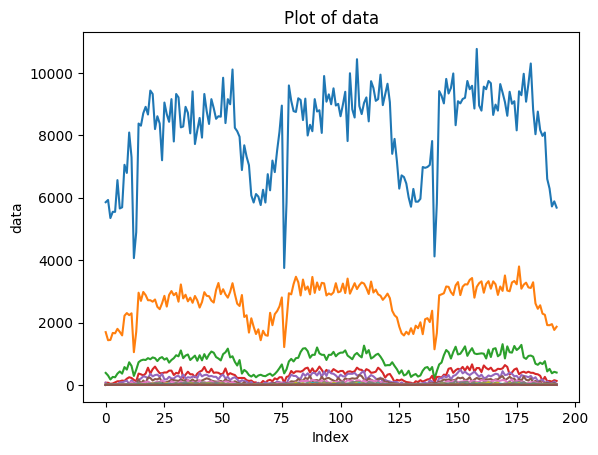

fetching  s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/feeps/brst/l2/electron/2020/02/mms1_feeps_brst_l2_electron_20200201075523_v6.1.1.cdf


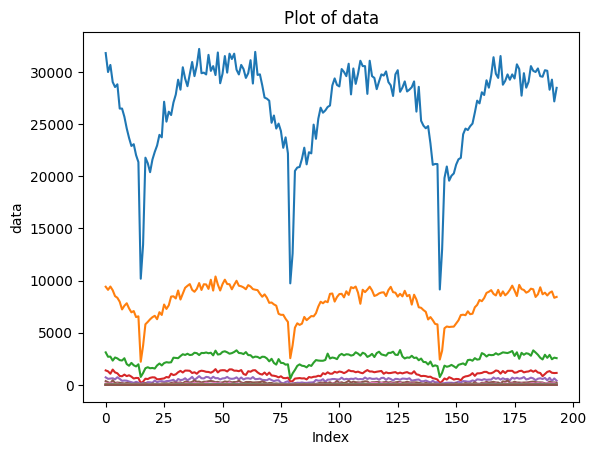

fetching  s3://gov-nasa-hdrl-data1/spdf/cdaweb/mms/mms1/feeps/brst/l2/electron/2020/02/mms1_feeps_brst_l2_electron_20200201081713_v6.1.1.cdf


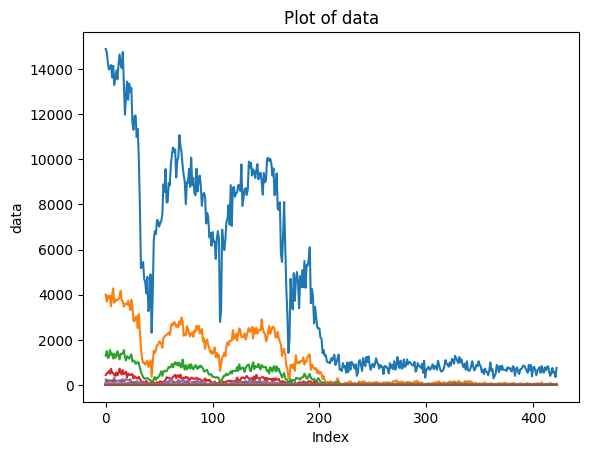

In [ ]:
print('# of zVariables | Start Date | File Size')
fr.stream_uri(file_registry1[:3], lambda s3_uri, d, e, f: plot_cdf(s3_uri, d, e, f))

That's it: find a dataset, get a list of files for a given time range, and operate on all the files in bulk.